In [2]:
!pip install 'aif360[Reductions]'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 4.2 MB/s eta 0:00:00


In [3]:
# Step 1: Install Required Libraries
!pip install -q aif360 shap mlflow ngrok pandas numpy scikit-learn matplotlib seaborn pyngrok

# Step 2: Import Libraries in Order
import os
import warnings
warnings.filterwarnings('ignore')

# Data Handling
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# IBM AI Fairness 360 (AIF360)
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

# SHAP for Explainability
import shap

# MLflow for Experiment Tracking
import mlflow
import mlflow.sklearn

# Ngrok for Exposing MLflow UI
from pyngrok import ngrok

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [122]:
!lsof -i :5000

COMMAND     PID USER   FD   TYPE DEVICE SIZE/OFF NODE NAME
gunicorn: 14644 root    5u  IPv4 424195      0t0  TCP *:5000 (LISTEN)
gunicorn: 14645 root    5u  IPv4 424195      0t0  TCP *:5000 (LISTEN)
gunicorn: 14650 root    5u  IPv4 424195      0t0  TCP *:5000 (LISTEN)
gunicorn: 14651 root    5u  IPv4 424195      0t0  TCP *:5000 (LISTEN)
gunicorn: 14652 root    5u  IPv4 424195      0t0  TCP *:5000 (LISTEN)


In [58]:
!kill -14483
!kill -14485

/bin/bash: line 1: kill: 14483: invalid signal specification
/bin/bash: line 1: kill: 14485: invalid signal specification


In [123]:
!ps -eo pid,lstart,cmd | grep gunicorn

  14644 Sat Apr 19 06:36:16 2025 gunicorn: master [mlflow.server:app]
  14645 Sat Apr 19 06:36:17 2025 gunicorn: worker [mlflow.server:app]
  14650 Sat Apr 19 06:36:17 2025 gunicorn: worker [mlflow.server:app]
  14651 Sat Apr 19 06:36:17 2025 gunicorn: worker [mlflow.server:app]
  14652 Sat Apr 19 06:36:17 2025 gunicorn: worker [mlflow.server:app]
  35231 Sat Apr 19 08:01:28 2025 /bin/bash -c ps -eo pid,lstart,cmd | grep gunicorn
  35233 Sat Apr 19 08:01:28 2025 grep gunicorn


In [61]:
import subprocess

# Start MLflow server in the background
mlflow_server = subprocess.Popen(
    ["mlflow", "server", "--host", "0.0.0.0", "--port", "5000"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

In [62]:
# Step 1: Install Required Libraries
!pip install -q mlflow pyngrok

# Step 2: Import Libraries
import os
from pyngrok import ngrok
import mlflow
import threading

# Step 3: Start MLflow Server in the Background
def start_mlflow_server():
    # Run MLflow server asynchronously
    os.system("mlflow server --host 0.0.0.0 --port 5000 > mlflow.log 2>&1 &")

# Use threading to run the MLflow server in the background
thread = threading.Thread(target=start_mlflow_server)
thread.start()

# Wait a few seconds to ensure the server starts
import time
time.sleep(5)

# Step 4: Set MLflow Tracking URI
mlflow.set_tracking_uri("http://localhost:5000")

# Step 5: Use ngrok to Expose MLflow UI
NGROK_AUTH_TOKEN = "2vvtFTsLEoeo1FIYFqEupTh03nf_7nGjiCmo1XFKR4s2eanX7"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Connect ngrok to MLflow server
public_url = ngrok.connect(5000)
print(f"MLflow UI available at: {public_url}")

MLflow UI available at: NgrokTunnel: "https://dc49-35-234-23-181.ngrok-free.app" -> "http://localhost:5000"


In [63]:
# Step 4: Load Dataset from Official Source
# Load German Credit Dataset from UCI Machine Learning Repository
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
column_names = [
    'status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings', 'employment',
    'installment_rate', 'personal_status', 'other_debtors', 'residence_since', 'property',
    'age', 'other_installment_plans', 'housing', 'existing_credits', 'job', 'num_dependents',
    'telephone', 'foreign_worker', 'label'
]

# Load dataset into a pandas DataFrame
dataset = pd.read_csv(dataset_url, header=None, names=column_names, delim_whitespace=True)

# Map labels to binary values (1 = Good, 0 = Bad)
dataset['label'] = dataset['label'].map({1: 1, 2: 0})

# Convert categorical features to numeric using one-hot encoding
dataset = pd.get_dummies(dataset, drop_first=True)

# Define protected attribute (age) and privileged/unprivileged groups
# Bin age into two categories: privileged (>= 25) and unprivileged (< 25)
dataset['age'] = (dataset['age'] >= 25).astype(int)

# Define protected attribute (age) and privileged/unprivileged groups
privileged_groups = [{'age': 1}]  # Age >= 25 (privileged)
unprivileged_groups = [{'age': 0}]  # Age < 25 (unprivileged)

# Split dataset into train and test
train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=42)

# Convert to AIF360-compatible BinaryLabelDataset
train_data_aif = BinaryLabelDataset(
    df=train_data,
    label_names=['label'],
    protected_attribute_names=['age']
)

test_data_aif = BinaryLabelDataset(
    df=test_data,
    label_names=['label'],
    protected_attribute_names=['age']
)

In [64]:
# Step 5: Bias Detection (Pre-processing)
metric_train = BinaryLabelDatasetMetric(
    train_data_aif,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

print(f"Disparate Impact (Train): {metric_train.disparate_impact()}")
print(f"Mean Difference (Train): {metric_train.mean_difference()}")

Disparate Impact (Train): 0.8002843938855313
Mean Difference (Train): -0.14407344719700477


In [65]:
# Step 6: Mitigate Bias Using Reweighing
reweighing = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
train_data_reweighted = reweighing.fit_transform(train_data_aif)

# Validate Bias Mitigation
metric_train_reweighted = BinaryLabelDatasetMetric(
    train_data_reweighted,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

print(f"Disparate Impact (Train after Reweighing): {metric_train_reweighted.disparate_impact()}")
print(f"Mean Difference (Train after Reweighing): {metric_train_reweighted.mean_difference()}")

Disparate Impact (Train after Reweighing): 1.0000000000000002
Mean Difference (Train after Reweighing): 2.220446049250313e-16


In [66]:
# Step 7: Train Model with Reweighted Data
X_train = train_data_reweighted.features
y_train = train_data_reweighted.labels.ravel()
X_test = test_data_aif.features
y_test = test_data_aif.labels.ravel()

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate Model Performance
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("\nModel Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Log model and metrics to MLflow
with mlflow.start_run():
    # Infer model signature
    from mlflow.models.signature import infer_signature
    signature = infer_signature(X_train, model.predict(X_train))

    # Define an input example
    input_example = X_train[:5]  # First 5 rows of training data as an example

    # Log model with signature and input example
    mlflow.log_param("model", "RandomForestClassifier")
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="credit_scoring_model",
        signature=signature,
        input_example=input_example
    )


Model Evaluation Metrics:
Accuracy: 0.7400
ROC AUC: 0.7809
🏃 View run capable-frog-38 at: http://localhost:5000/#/experiments/0/runs/c10d8e08aae84122a11fb3c0d21652e3
🧪 View experiment at: http://localhost:5000/#/experiments/0


In [68]:
# Step 8: Evaluate Fairness Post-Processing
test_pred = model.predict(X_test)
test_pred_prob = model.predict_proba(X_test)[:, 1]

# Convert predictions to BinaryLabelDataset
test_pred_dataset = test_data_aif.copy()
test_pred_dataset.labels = test_pred

metric_test = ClassificationMetric(
    test_data_aif,
    test_pred_dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

print("\nPost-Processing Fairness Metrics:")
print(f"Equal Opportunity Difference (Test): {metric_test.equal_opportunity_difference():.4f}")
print(f"Disparate Impact (Test): {metric_test.disparate_impact():.4f}")


Post-Processing Fairness Metrics:
Equal Opportunity Difference (Test): -0.0885
Disparate Impact (Test): 0.8692


In [69]:
# Step 8: Evaluate Fairness Post-Processing
test_pred = model.predict(X_test)
test_pred_prob = model.predict_proba(X_test)[:, 1]

# Convert predictions to BinaryLabelDataset
test_pred_dataset = test_data_aif.copy()
test_pred_dataset.labels = test_pred

metric_test = ClassificationMetric(
    test_data_aif,
    test_pred_dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

print(f"Equal Opportunity Difference (Test): {metric_test.equal_opportunity_difference()}")
print(f"Disparate Impact (Test): {metric_test.disparate_impact()}")

Equal Opportunity Difference (Test): -0.08845338983050843
Disparate Impact (Test): 0.8691588785046729


<Figure size 640x480 with 0 Axes>

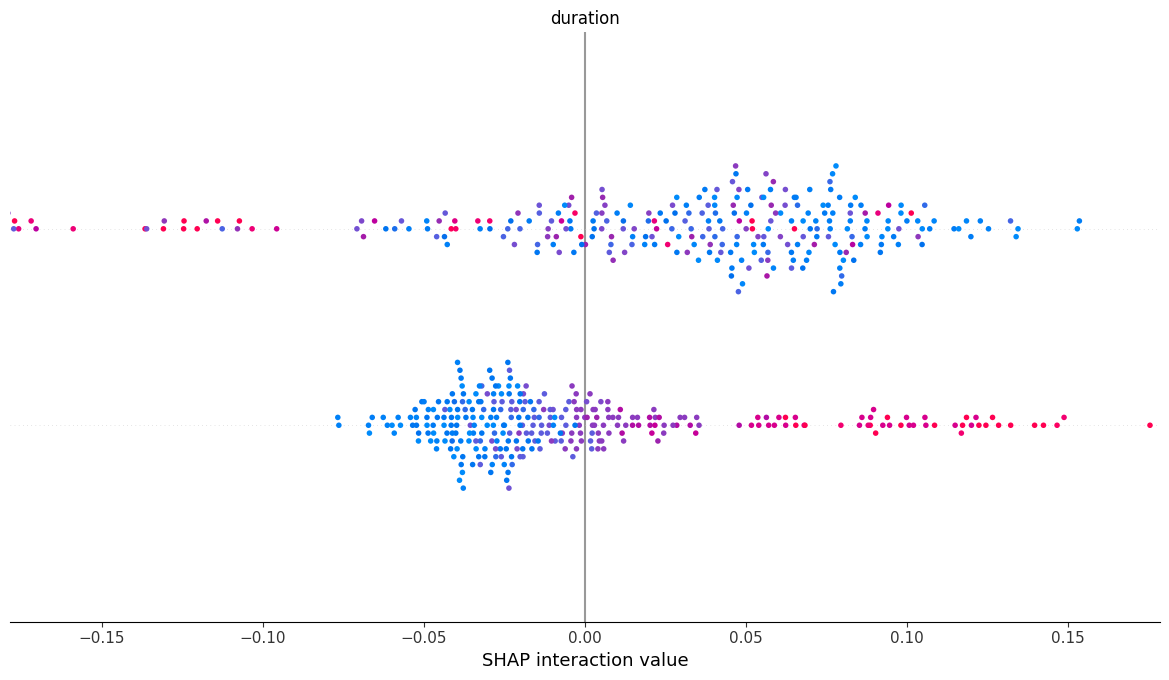

In [70]:
# Step 9: SHAP Explainability
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test, feature_names=test_data.columns[:-1])

# Stop MLflow Run
mlflow.end_run()

In [73]:
import subprocess

# Start MLflow model server in the background
subprocess.Popen(
    "mlflow models serve -m runs:/c10d8e08aae84122a11fb3c0d21652e3/credit_scoring_model -p 14644 --no-conda > mlflow_server.log 2>&1",
    shell=True
)

print("MLflow model server started in the background.")

MLflow model server started in the background.


In [74]:
!cat mlflow_server.log

2025/04/19 06:39:55 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'
2025/04/19 06:39:55 INFO mlflow.pyfunc.backend: === Running command 'exec uvicorn --host 127.0.0.1 --port 14644 --workers 1 mlflow.pyfunc.scoring_server.app:app'
INFO:     Started server process [15661]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:14644 (Press CTRL+C to quit)


In [83]:
import requests
import json

# Define the API endpoint
url = "http://127.0.0.1:14644/invocations"
# Define sample input data (convert to native Python types)
input_data = {
    "columns": list(test_data.columns[:-1]),  # Exclude the label column
    "data": [list(map(lambda x: x.item() if hasattr(x, "item") else x, test_data.iloc[0][:-1]))]
}

# Wrap the input data in the "dataframe_split" key
payload = {"dataframe_split": input_data}

# Send POST request to the REST API
headers = {"Content-Type": "application/json"}
response = requests.post(url, data=json.dumps(payload), headers=headers)

# Print the prediction
print("Prediction:", response.json())

Prediction: {'predictions': [1.0]}


In [84]:
from pyngrok import ngrok

# Set ngrok authentication token
NGROK_AUTH_TOKEN = "2vvtFTsLEoeo1FIYFqEupTh03nf_7nGjiCmo1XFKR4s2eanX7"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Connect ngrok to the MLflow server
public_url = ngrok.connect(14644)
print(f"REST API available at: {public_url}")

REST API available at: NgrokTunnel: "https://8c26-35-234-23-181.ngrok-free.app" -> "http://localhost:14644"


In [100]:
import requests
import json

# Define the ngrok API endpoint
ngrok_url = "https://8c26-35-234-23-181.ngrok-free.app/invocations"

# Prepare input data
input_data = {
    "columns": list(test_data.columns[:-1]),  # Exclude the label column
    "data": [
        list(map(lambda x: x.item() if hasattr(x, "item") else x, test_data.iloc[0][:-1]))
    ]
}

# Wrap the input data in the "dataframe_split" key
payload = {"dataframe_split": input_data}

# Send POST request to the REST API
headers = {"Content-Type": "application/json"}
response = requests.post(ngrok_url, data=json.dumps(payload), headers=headers)

# Print the prediction
print("Prediction:", response.json())

Prediction: {'predictions': [1.0]}


In [96]:
import json

# Define the JSON payload
payload = {
    "dataframe_split": {
        "columns": list(input_df.columns),
        "data": [list(input_df.iloc[0])]  # First row of input data
    }
}

# Convert the payload to a JSON string
json_payload = json.dumps(payload)

# Use the JSON payload in the curl command
!curl -X POST https://8c26-35-234-23-181.ngrok-free.app/invocations \
     -H "Content-Type: application/json" \
     -d '{json_payload}'

{"predictions": [1.0]}

In [111]:
# Create a DataFrame with feature names and values for the first row
first_row = train_data.iloc[0]  # First row of the dataset
feature_values_df = pd.DataFrame({
    "Feature Name": first_row.index[:-1],  # Exclude the label column
    "Value": first_row.values[:-1]
})

# Print the DataFrame
print(feature_values_df)

                    Feature Name  Value
0                       duration     24
1                  credit_amount   2032
2               installment_rate      4
3                residence_since      4
4                            age      1
5               existing_credits      2
6                 num_dependents      1
7                          label      1
8                     status_A12  False
9                     status_A13  False
10                    status_A14   True
11            credit_history_A31  False
12            credit_history_A32  False
13            credit_history_A33   True
14            credit_history_A34  False
15                   purpose_A41  False
16                  purpose_A410  False
17                   purpose_A42  False
18                   purpose_A43  False
19                   purpose_A44  False
20                   purpose_A45  False
21                   purpose_A46  False
22                   purpose_A48  False
23                   purpose_A49  False


In [126]:
import mlflow

# Define the run ID and model path
run_id = "c10d8e08aae84122a11fb3c0d21652e3"  # Replace with your actual run ID
model_uri = f"runs:/{run_id}/credit_scoring_model"

# Save the model locally
local_model_path = "./credit_scoring_model"
downloaded_path = mlflow.artifacts.download_artifacts(artifact_uri=model_uri, dst_path=local_model_path)

print(f"Model saved locally at: {downloaded_path}")

Model saved locally at: /content/credit_scoring_model/credit_scoring_model


In [127]:
import os
print(os.listdir("./credit_scoring_model"))

['credit_scoring_model']


In [130]:
import shutil

source_dir = "./credit_scoring_model"
output_zip = "./credit_scoring_model.zip"

shutil.make_archive(output_zip.replace(".zip", ""), 'zip', source_dir)

print(f"Model zipped successfully at: {output_zip}")

Model zipped successfully at: ./credit_scoring_model.zip


In [131]:
from google.colab import files

# Download the ZIP file
files.download("./credit_scoring_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>